In [1]:
from decimal import Decimal
import pandas
import numpy
import itertools
import functools
import operator
from pprint import pprint

import market
import simulate
import metrics
import lens
import withdrawal
import harvesting
import mortality
from portfolio import Portfolio

import seaborn
import matplotlib
from matplotlib import pyplot as plt
seaborn.set(style="whitegrid")
seaborn.set_context('poster')

In [2]:
def plot(sim, year, lens, title):
    plt.figure(figsize=(12,6))
    plt.title(title)
    s = pandas.Series([lens(n) for n in sim], index=range(year, year+len(sim)))
    g = seaborn.lineplot(data=s)
    seaborn.despine(left=True, bottom=True, offset=20)
    g.axes.yaxis.set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))    

In [3]:
Market = market.Returns_US_1871()

In [4]:
def get_next_stock_pct(returns):
    for r in returns:
        if r.stocks > r.bonds:
            yield Decimal(1)
        else:
            yield Decimal(0)

class PerfectAA(harvesting.AnnualRebalancing):
    def __init__(self, portfolio, returns):
        self.stock_i = get_next_stock_pct(returns)
        super().__init__(portfolio, 0)
                        
    def do_harvest(self, amount):
        self.stock_pct = self.stock_i.send(None)
        super().do_harvest(amount)

def get_best_aa(returns, length=30, rate=4):
    r_list = list(returns)
    r = r_list[0:length]
    c_max = 0
    best_aa = None
    for aa in range(101):
        bb = 100 - aa
        vs = [((n.stocks * aa/100) + (n.bonds * bb/100))+1 for n in r]
        s = 100
        c = 0
        r_wd = rate
        for v, i in zip(vs, [n.inflation for n in r]):
            s = (s - r_wd) * v
            if s > 0:
                c += 1
            r_wd *= (1+i)
        if s > 0:
            c += s/r_wd
        if c >= c_max:
            c_max = c
            best_aa = aa
    return best_aa

In [5]:
print(get_best_aa(Market.iter_from(1929)))

52


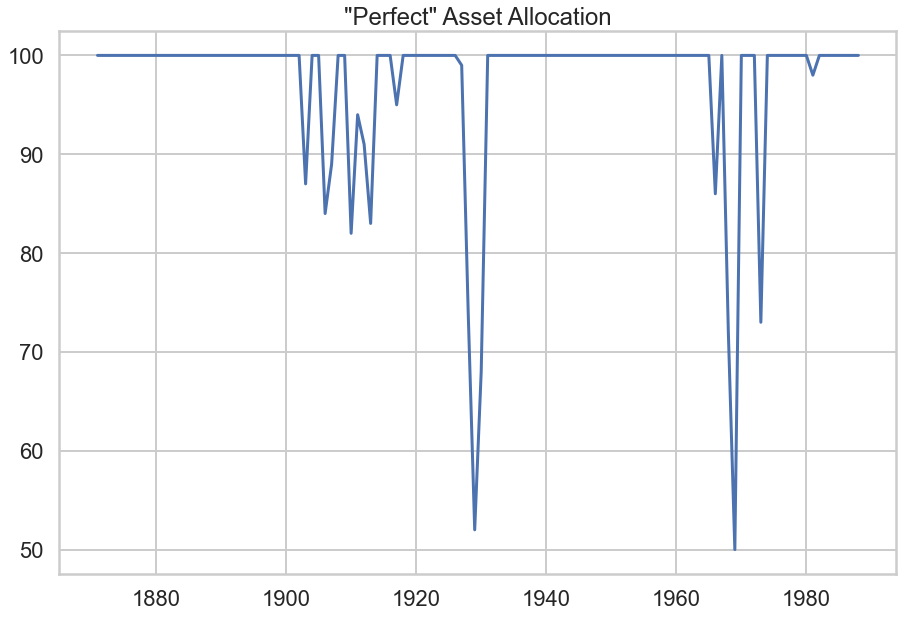

In [6]:
d = []
for i in range(1871, 2019-30):
    d.append(get_best_aa(Market.iter_from(i)))
s = pandas.Series(data=d, index=range(1871,2019-30))
s.plot(figsize=(15,10), title='"Perfect" Asset Allocation')

In [7]:
# Picks the best AA
def run_best(length=30, rate=Decimal('.04'), lens_fn=lens.calc_years_sustained):
    d = []

    for Year in range(1871, 2019-length):
        m1, m2 = itertools.tee(Market.iter_from(Year))
        best_aa = get_best_aa(m2, length=length, rate=100*rate) / 100
    #    print(Year, best_aa)
        sim = simulate.withdrawals(m1,
                             harvesting=harvesting.make_rebalancer(best_aa),
                             withdraw=lambda p, h: withdrawal.ConstantDollar(p, h, rate=rate))
        sustained = lens_fn(sim)
        d.append(sustained)

    return pandas.Series(index=range(1871, 2019-length), dtype=float, data=d)
bestaa = run_best()
bestaa.head()

1871    272.480265
1872    240.272728
1873    220.055741
1874    212.631076
1875    171.945698
dtype: float64

In [8]:
# Uses PerfectAA
def run_perfect(length=30, rate=Decimal('.04'), lens_fn=lens.calc_years_sustained):
    d = []

    for Year in range(1871, 2019-length):
        m1, m2 = itertools.tee(Market.iter_from(Year))
        sim = simulate.withdrawals(m1,
                             harvesting=lambda p: PerfectAA(p, m2),
                             withdraw=lambda p, h: withdrawal.ConstantDollar(p, h, rate=rate))
        #plot(sim, Year, lambda n: float(n.portfolio_pre.value_r))
        sustained = lens_fn(sim)
        d.append(sustained)

    return pandas.Series(index=range(1871, 2019-length), dtype=float, data=d)
perfect = run_perfect()
perfect.head()

1871    2281.367910
1872    2096.450582
1873    1967.781221
1874    1841.729960
1875    1612.574203
dtype: float64

In [9]:
def run_constant(length=30, rate=Decimal('.04'), aa=Decimal('.6'), lens_fn=lens.calc_years_sustained):
    d = []

    for Year in range(1871, 2019-length):
        m1, m2 = itertools.tee(Market.iter_from(Year))
        sim = simulate.withdrawals(m1,
                             harvesting=harvesting.make_rebalancer(aa),
                             withdraw=lambda p, h: withdrawal.ConstantDollar(p, h, rate=rate))
        sustained = lens_fn(sim)
        d.append(sustained)

    return pandas.Series(index=range(1871, 2019-length), dtype=float, data=d)
sixty = run_constant()
sixty.head()

1871    172.877811
1872    165.388583
1873    155.738400
1874    145.682563
1875    117.516381
dtype: float64

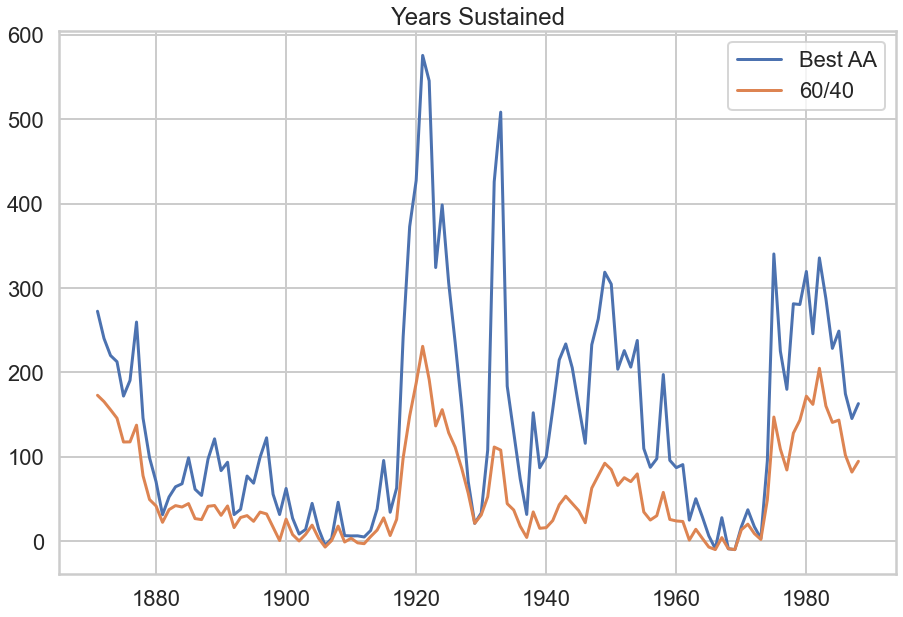

In [10]:
df = pandas.DataFrame(data={'Best AA': bestaa, '60/40': sixty})
df.plot(figsize=(15,10), title='Years Sustained')

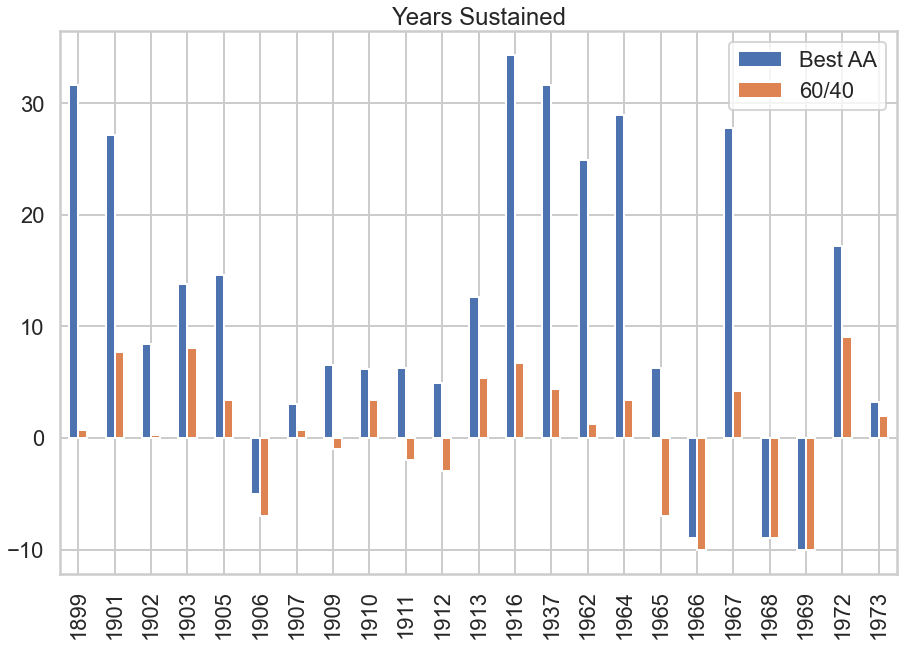

In [11]:
df[df['60/40']<10].plot(kind='bar', figsize=(15,10), title='Years Sustained')

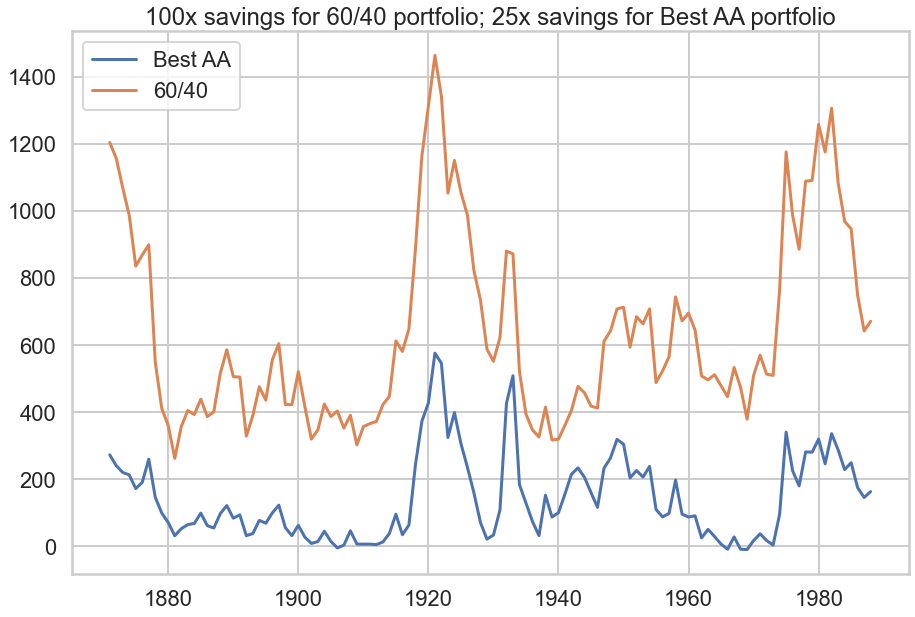

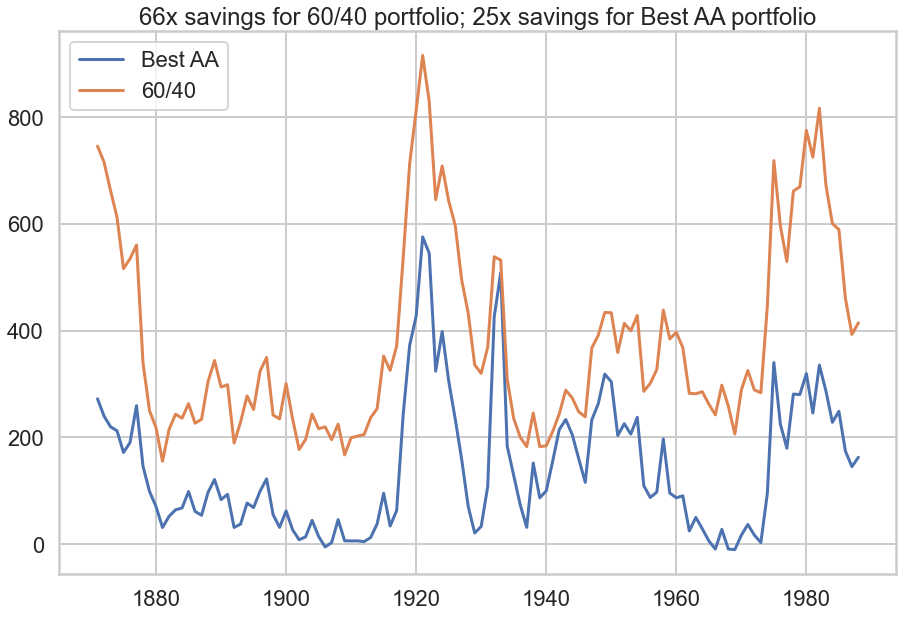

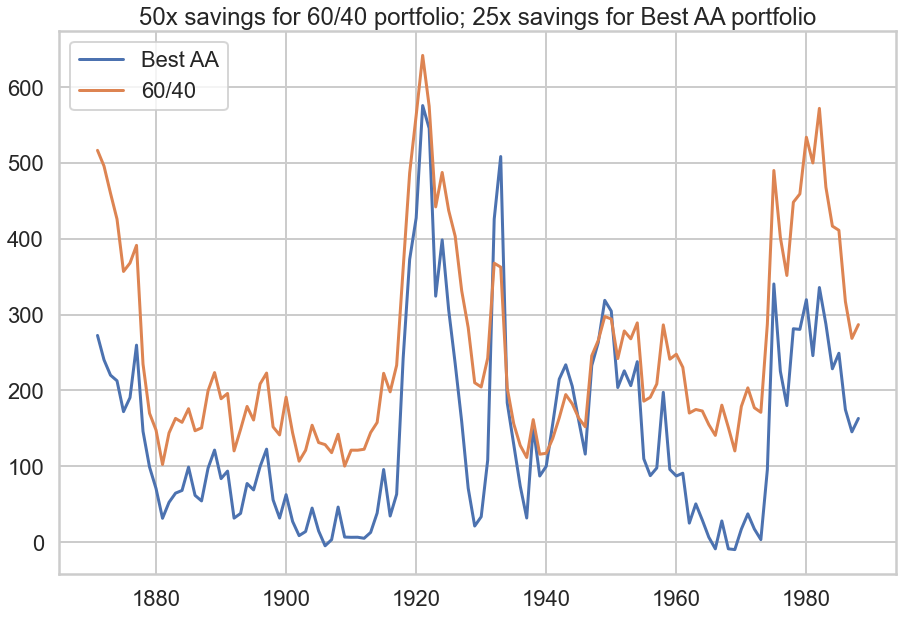

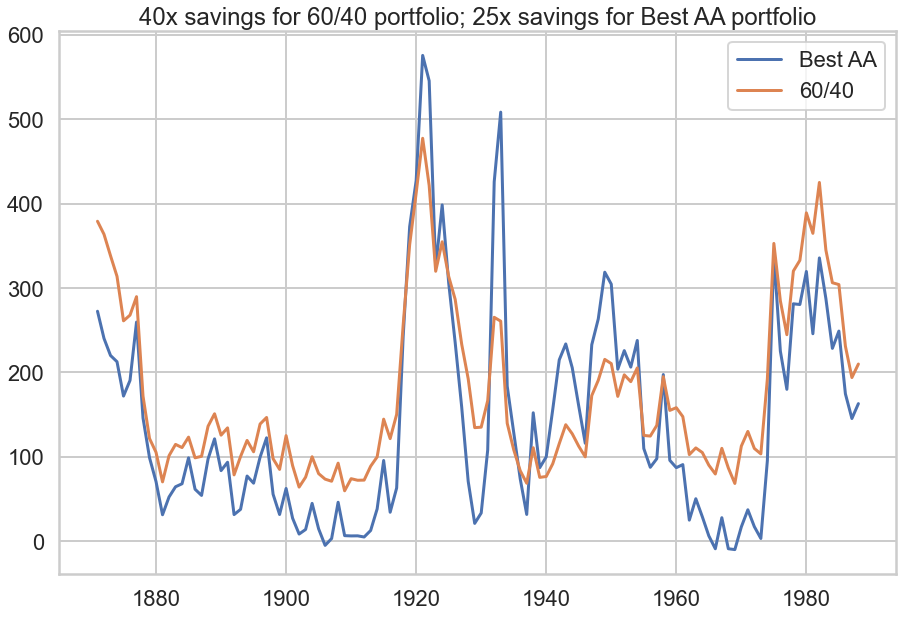

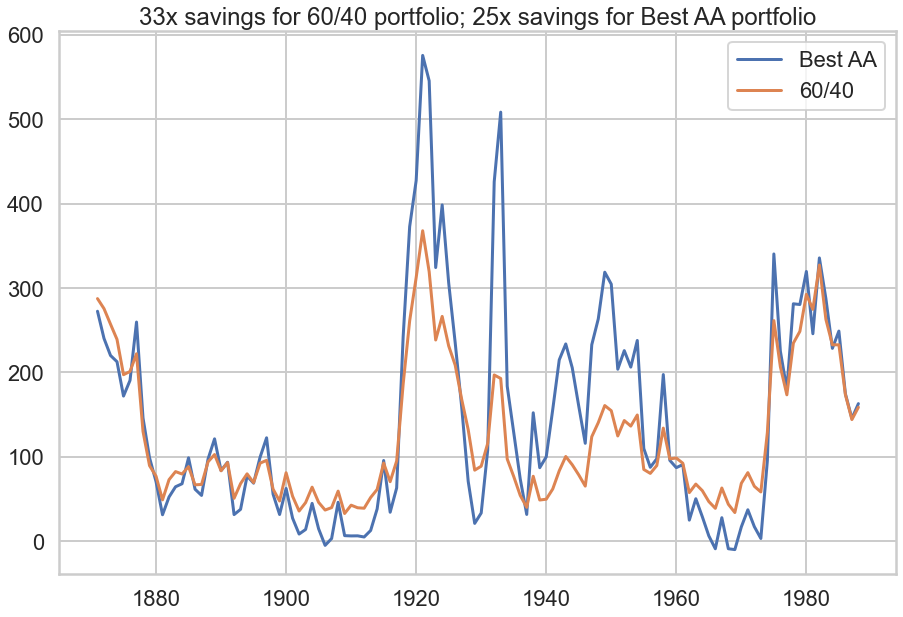

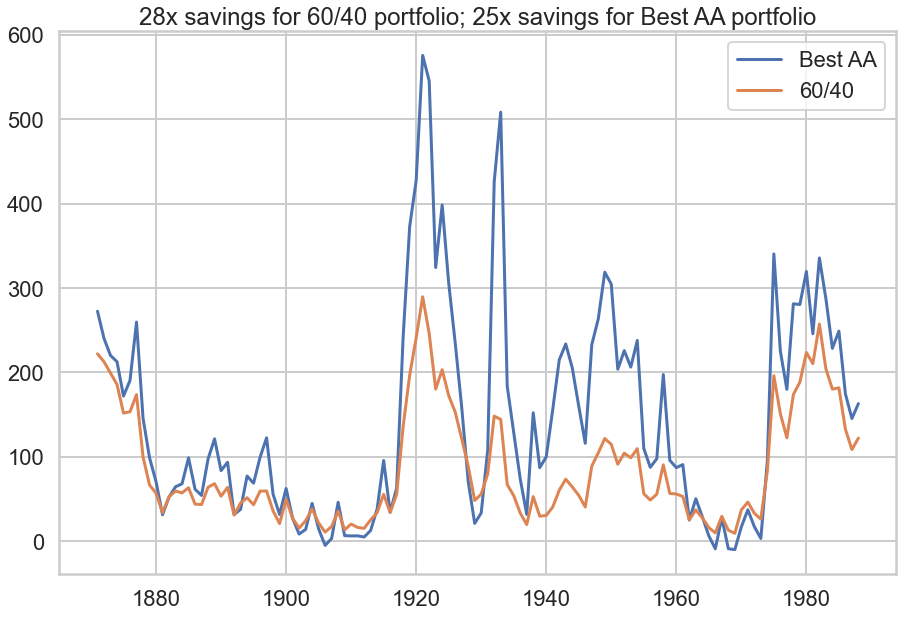

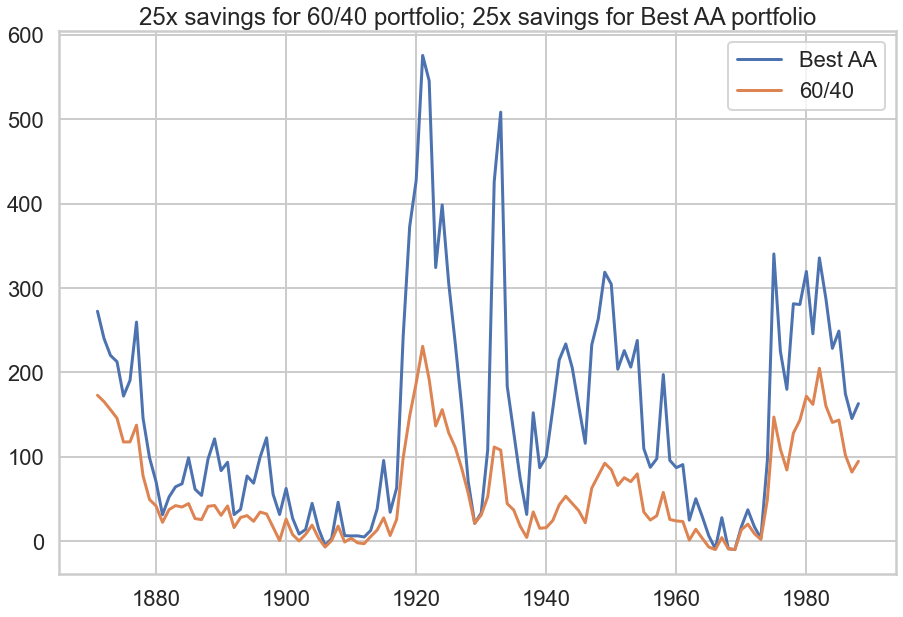

In [12]:
for r in range(10, 41, 5):
    rate = Decimal(r) / 1000
    sixty = run_constant(rate=rate)
    df = pandas.DataFrame(data={'Best AA': bestaa, '60/40': sixty})
    df.plot(figsize=(15,10), title=f'{int(1/rate)}x savings for 60/40 portfolio; 25x savings for Best AA portfolio')

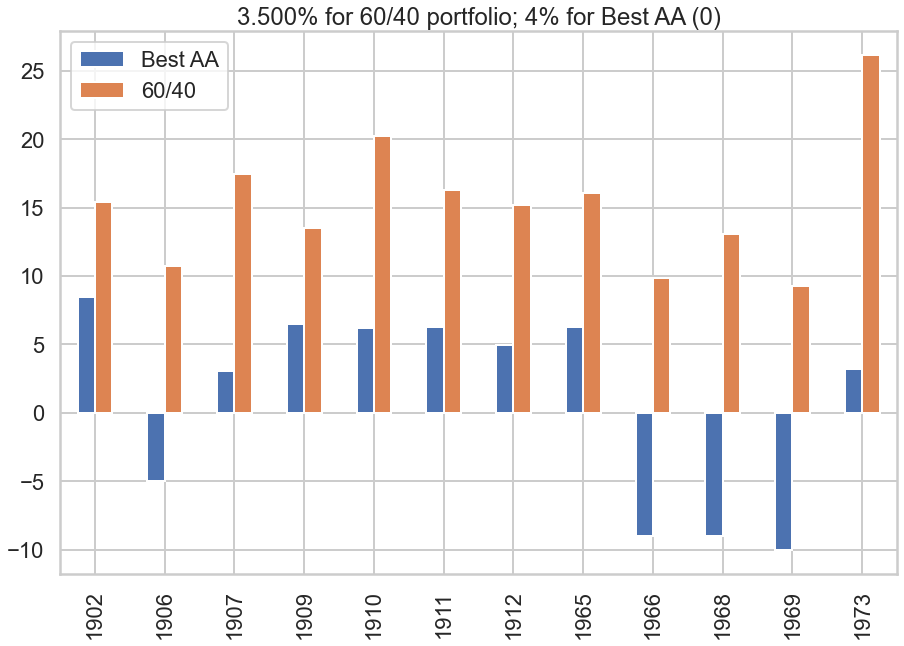

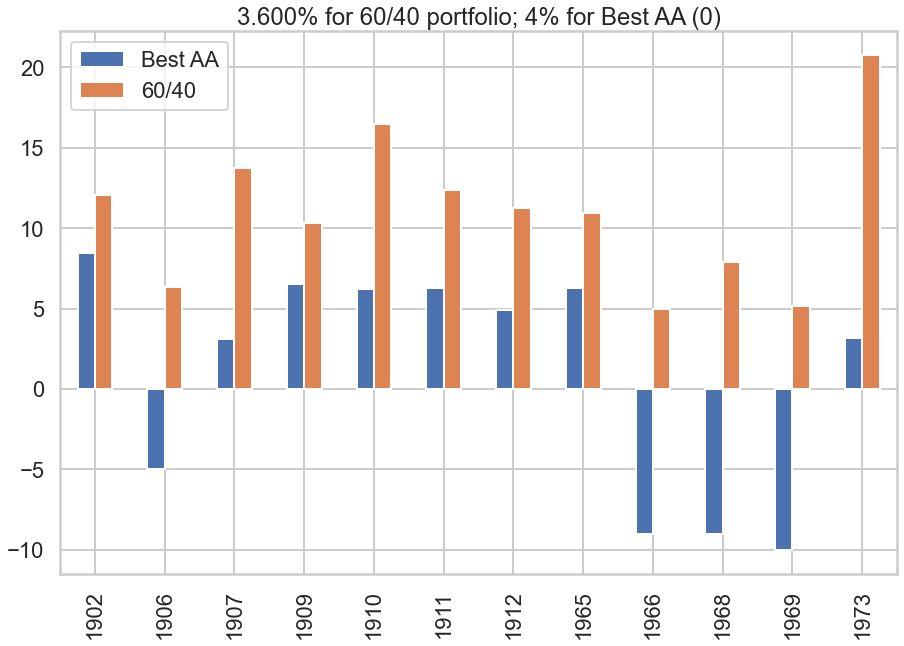

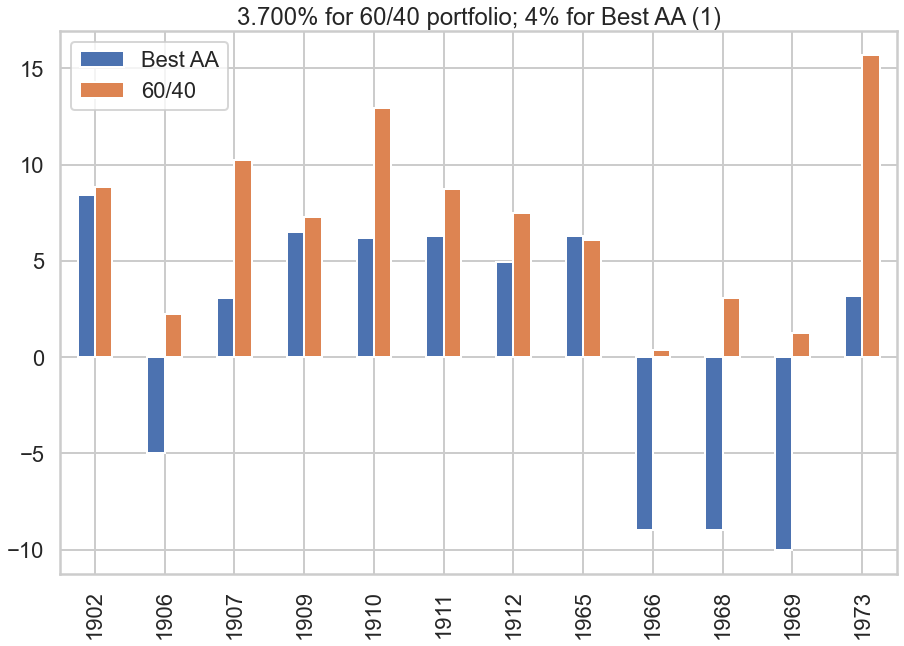

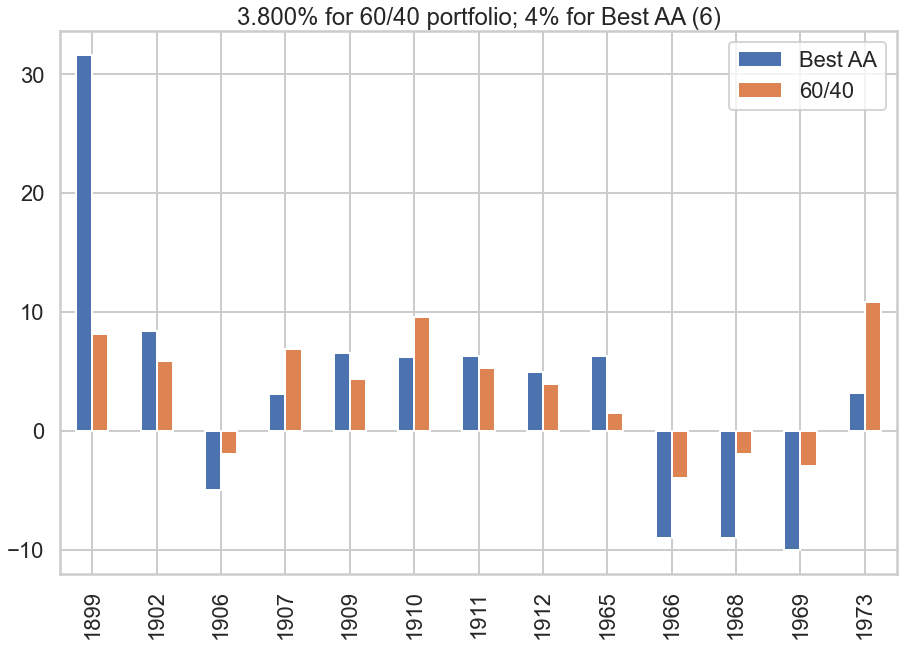

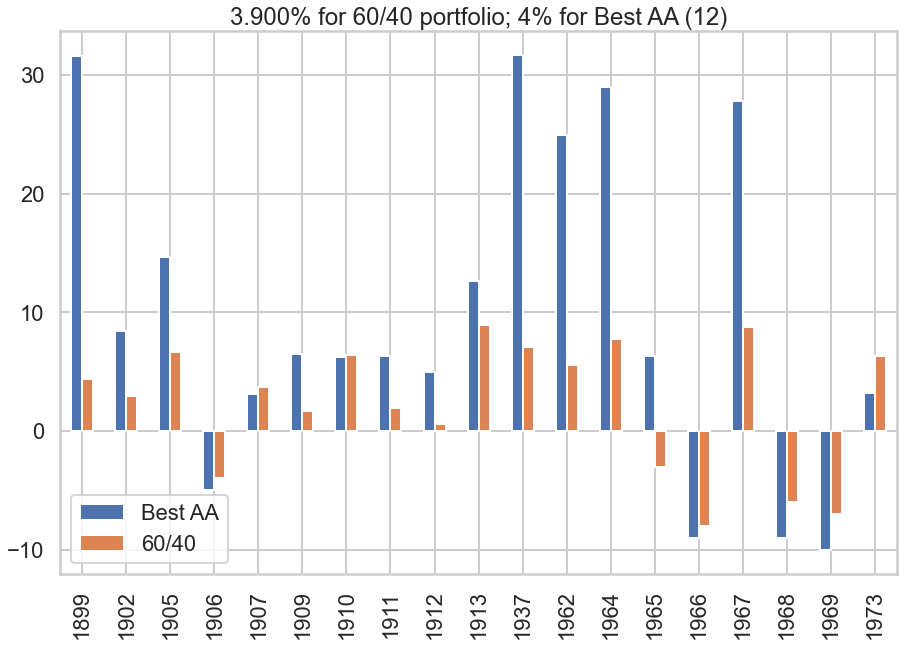

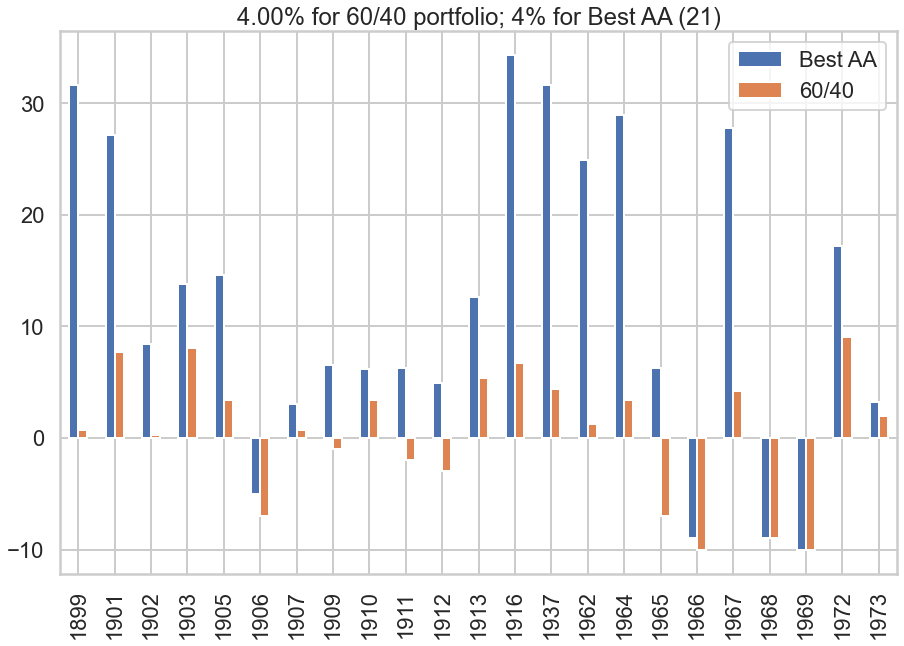

In [13]:
for r in range(35, 41):
    rate = Decimal(r) / 1000
    sixty = run_constant(rate=rate)
    df = pandas.DataFrame(data={'Best AA': bestaa, '60/40': sixty})
    n = df[df.apply(lambda r: (r<10).any(), axis=1)]
    c = df[(df['60/40'] < 10) & (df['Best AA'] > df['60/40'])]
    n.plot(kind='bar', figsize=(15,10), title=f'{rate*100}% for 60/40 portfolio; 4% for Best AA ({len(c)})')

# Coverage Ratio

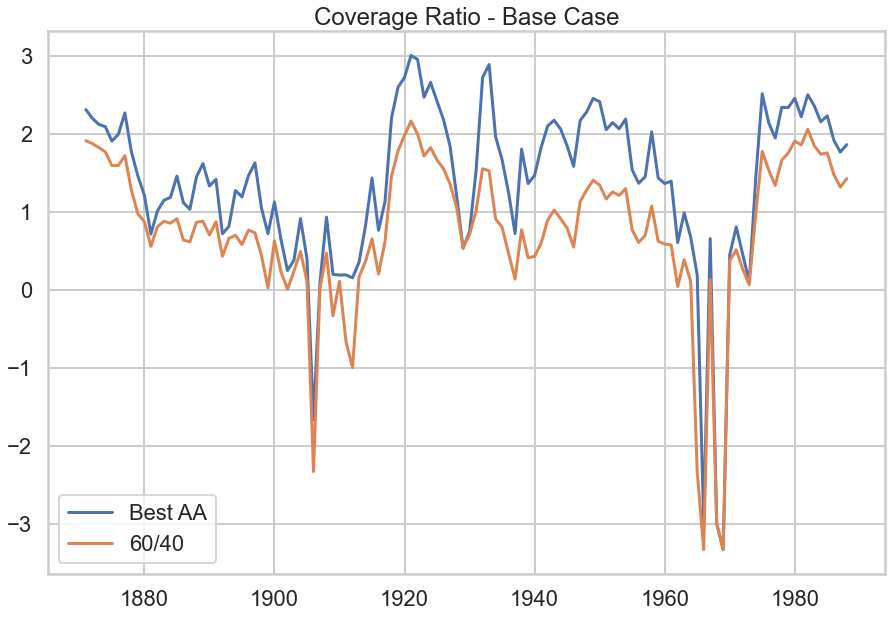

In [14]:
bestaa = run_best(lens_fn=lambda x: lens.calc_coverage_ratio(x, 30))
sixty = run_constant(lens_fn=lambda x: lens.calc_coverage_ratio(x, 30))
df = pandas.DataFrame(data={'Best AA': bestaa, '60/40': sixty})
df.plot(figsize=(15,10), title='Coverage Ratio - Base Case')

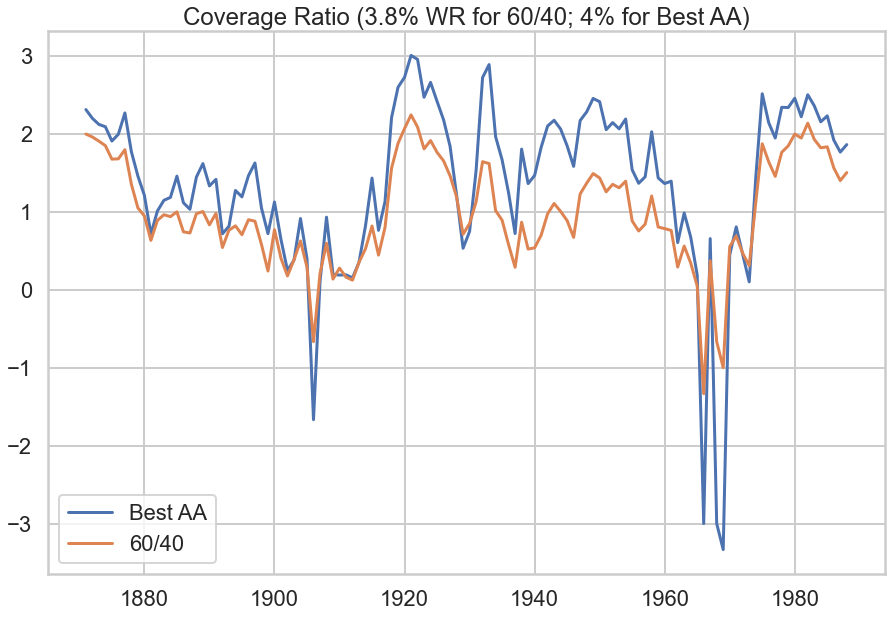

In [15]:
bestaa = run_best(lens_fn=lambda x: lens.calc_coverage_ratio(x, 30))
sixty = run_constant(lens_fn=lambda x: lens.calc_coverage_ratio(x, 30), rate=Decimal('0.038'))
df = pandas.DataFrame(data={'Best AA': bestaa, '60/40': sixty})
df.plot(figsize=(15,10), title='Coverage Ratio (3.8% WR for 60/40; 4% for Best AA)')

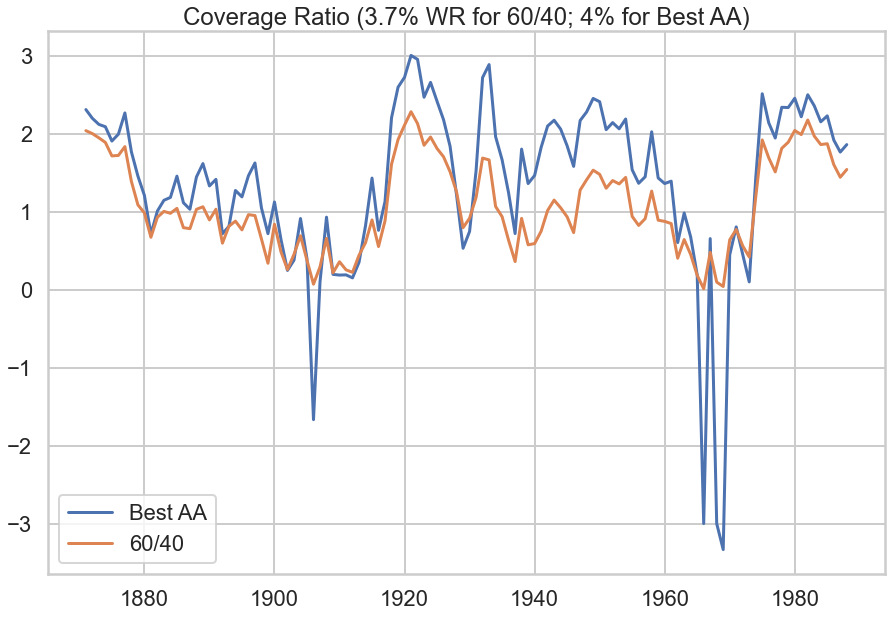

In [16]:
bestaa = run_best(lens_fn=lambda x: lens.calc_coverage_ratio(x, 30))
sixty = run_constant(lens_fn=lambda x: lens.calc_coverage_ratio(x, 30), rate=Decimal('0.037'))
df = pandas.DataFrame(data={'Best AA': bestaa, '60/40': sixty})
df.plot(figsize=(15,10), title='Coverage Ratio (3.7% WR for 60/40; 4% for Best AA)')

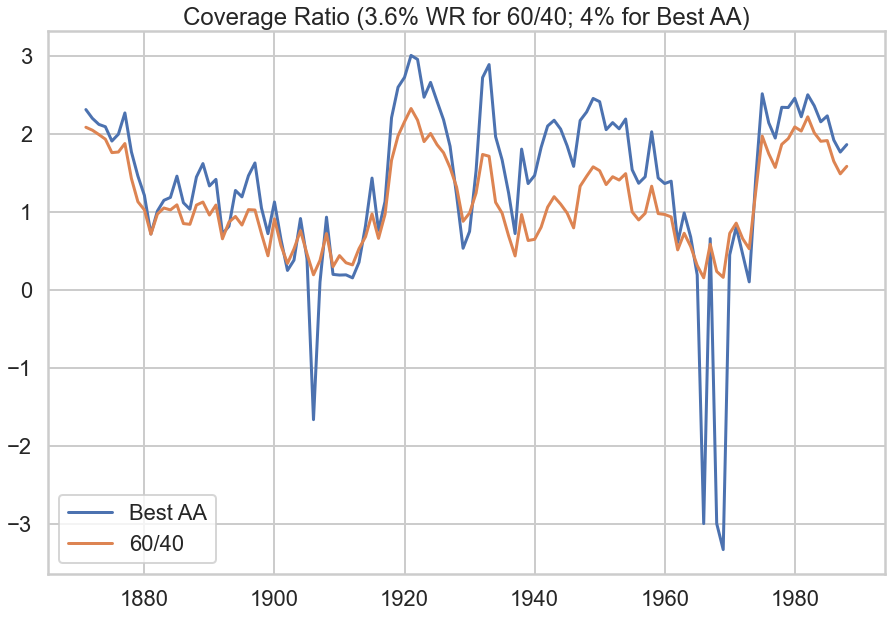

In [17]:
bestaa = run_best(lens_fn=lambda x: lens.calc_coverage_ratio(x, 30))
sixty = run_constant(lens_fn=lambda x: lens.calc_coverage_ratio(x, 30), rate=Decimal('0.036'))
df = pandas.DataFrame(data={'Best AA': bestaa, '60/40': sixty})
df.plot(figsize=(15,10), title='Coverage Ratio (3.6% WR for 60/40; 4% for Best AA)')

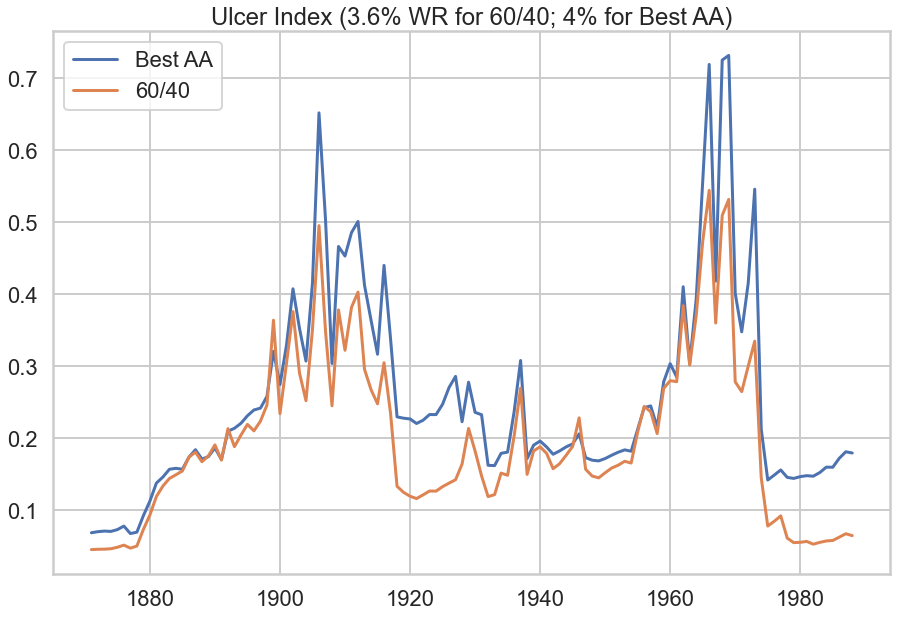

In [18]:
bestaa = run_best(lens_fn=lens.calc_ulcer)
sixty = run_constant(lens_fn=lens.calc_ulcer, rate=Decimal('0.036'))
df = pandas.DataFrame(data={'Best AA': bestaa, '60/40': sixty})
df.plot(figsize=(15,10), title='Ulcer Index (3.6% WR for 60/40; 4% for Best AA)')

# Finding the best AA for every year

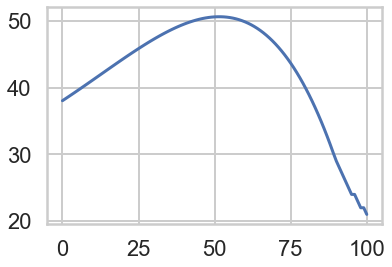

In [19]:
def get_years_sustained_by_aa(returns, length=30, rate=4):
    r_list = list(returns)
    r = r_list[0:length]
    c_max = 0
    c_list = []
    for aa in range(101):
        bb = 100 - aa
        vs = [((n.stocks * aa/100) + (n.bonds * bb/100))+1 for n in r]
        s = 100
        c = 0
        r_wd = rate
        for v, i in zip(vs, [n.inflation for n in r]):
            s = (s - r_wd) * v
            if s > 0:
                c += 1
            r_wd *= (1+i)

        if s > 0:
            c += s/r_wd
        c_list.append(c)
    return pandas.Series(data=c_list, index=range(101), dtype=float)
get_years_sustained_by_aa(Market.iter_from(1929)).plot()

In [20]:
d = {}
for year in range(1871, 2019-30):
    d[year] = get_years_sustained_by_aa(Market.iter_from(year))
df = pandas.DataFrame.from_dict(d, dtype=float)
df.head()

,1871,1872,1873,1874,1875,1876,1877,1878,1879,1880,...,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988
0,90.778838,93.456108,91.190879,86.497110,73.208299,65.792147,63.276863,51.286767,43.220913,52.289083,...,57.590317,67.008034,84.121085,94.660826,72.180562,72.863485,68.951134,57.032376,48.142516,52.322915
1,91.693315,94.357576,92.018654,87.280186,74.027931,66.601290,64.201446,52.012866,43.830153,52.796251,...,58.392156,67.811857,84.838782,95.577669,73.039031,73.711617,69.882978,57.730655,48.745971,53.043018
2,92.613827,95.264669,92.850975,88.066593,74.855315,67.420580,65.141182,52.749011,44.450180,53.309595,...,59.198840,68.621313,85.557620,96.496937,73.904115,74.567624,70.826594,58.437148,49.358155,53.774934
3,93.540321,96.177327,93.687779,88.856254,75.690423,68.250038,66.096200,53.495230,45.081064,53.829121,...,60.010252,69.436286,86.277462,97.418469,74.775718,75.431425,71.781964,59.151822,49.979070,54.518710
4,94.472743,97.095490,94.528998,89.649090,76.533227,69.089682,67.066627,54.251552,45.722875,54.354836,...,60.826272,70.256658,86.998165,98.342100,75.653739,76.302935,72.749066,59.874637,50.608715,55.274387


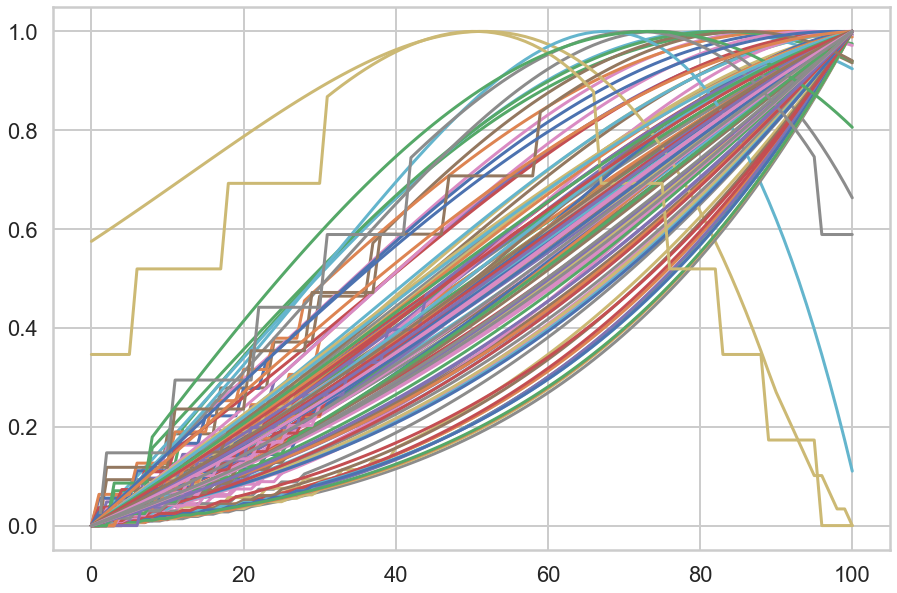

In [21]:
normalized_df=(df-df.min())/(df.max()-df.min())
normalized_df.plot(legend=False, figsize=(15,10))

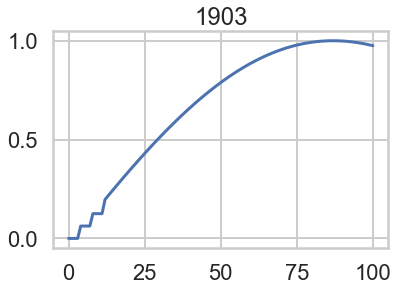

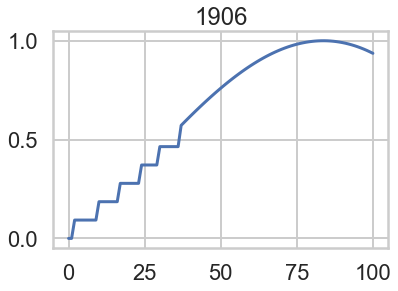

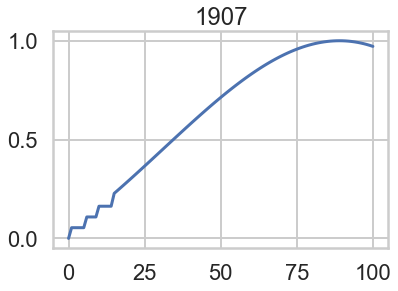

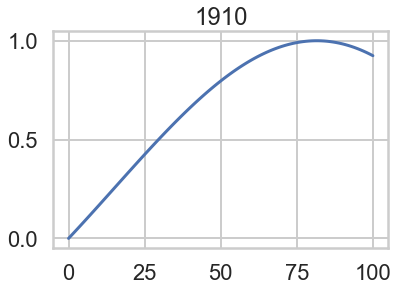

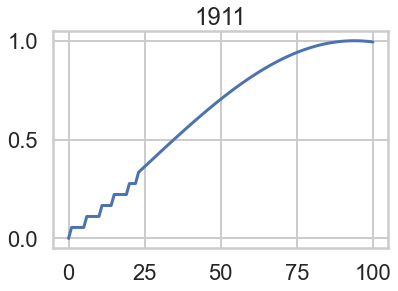

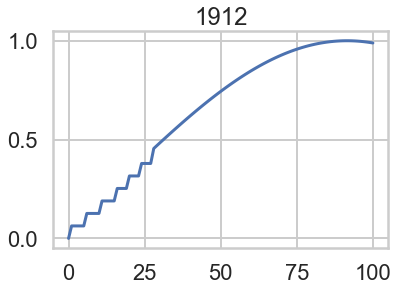

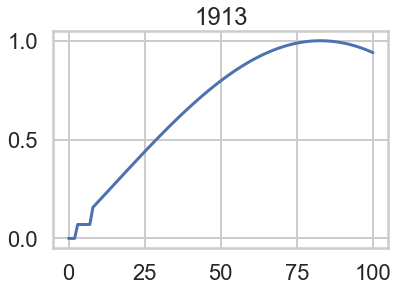

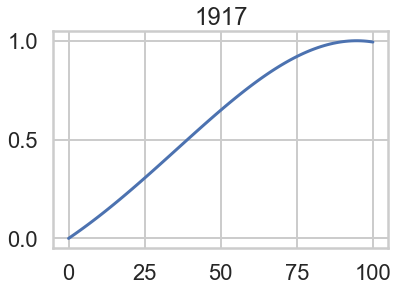

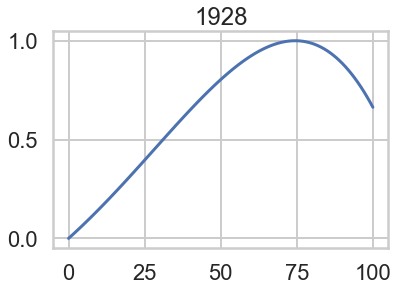

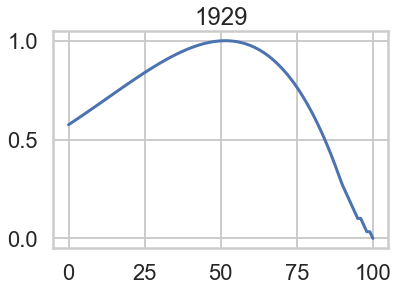

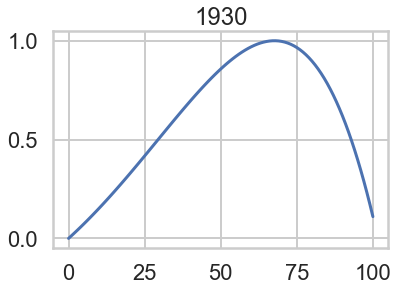

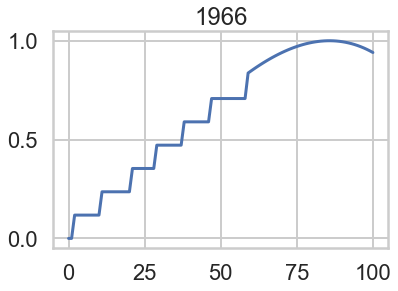

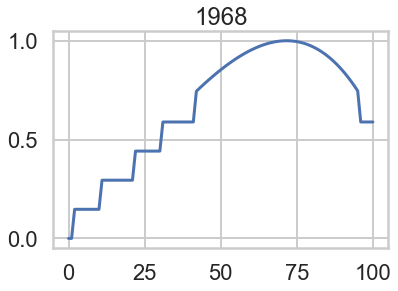

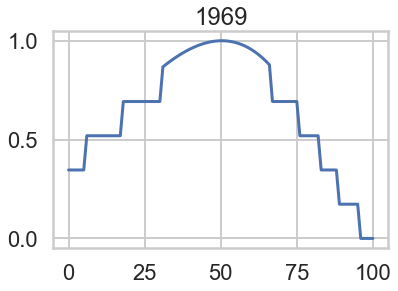

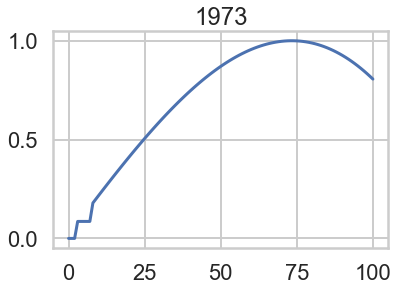

In [22]:
for year in range(1871, 2019-30):
    s = get_years_sustained_by_aa(Market.iter_from(year))
    n=(s-s.min())/(s.max()-s.min())
    if not (n[100] > n[95] > n[90] > n[80] > n[70]):
        n.plot(title=f'{year}')
    plt.show()

In [35]:
class LowerYields(market.Returns_US_1871):
    def __init__(self):
        super().__init__(self)
        self.dataframe = pandas.read_csv('1871_returns.csv')
        self.dataframe['IT Bonds'] = self.dataframe['IT Bonds'] - 5
    
M = LowerYields()
M.dataframe.head()

,Year,IT Bonds,VFINX,CPI-U,CAPE10
0,1871,-2.741793,15.598567,1.527035,NaN
1,1872,-1.983944,11.190207,2.255461,NaN
2,1873,2.885968,-2.506504,-4.412050,NaN
3,1874,4.908582,4.671016,-6.922563,NaN
4,1875,0.928596,5.312054,-5.785601,NaN


In [36]:
years = 30

def run(stock_pct):
    swrs = pandas.Series()
    for _ in range(1871, 2019-30):
        returns = []
        for one_year in zip(range(years), M.iter_from(_)):
            annual_returns = one_year[1]
            stocks = ((1+annual_returns.stocks) / (1+annual_returns.inflation)) - 1
            bonds = ((1+annual_returns.bonds) / (1+annual_returns.inflation)) - 1
            returns.append((stocks * stock_pct) + (bonds * (1-stock_pct)))
        swr = float(metrics.pwa(100, 0, returns))
        swrs.loc[_] = swr
    return swrs
s = run(Decimal('.6'))
s.sort_values()

/Users/justus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


1966    3.150903
1969    3.215149
1968    3.224214
1906    3.243466
1965    3.259818
          ...   
1874    7.522552
1985    7.523853
1877    7.934652
1982    8.166093
1921    8.199374
Length: 118, dtype: float64